# SONG GENRE CLASSIFICATION project notebook

Pere Ginebra, Joan Domingo

APA Q1 2021/22

FIB UPC

# Readme

The dataset used in this project can be found here: https://www.kaggle.com/vicsuperman/prediction-of-music-genre

To run the whole notebook you can use the run all/restart and run all button. Some cells are used to look for the best parameters for a model and therefore take very long to execute, these are labeled by a text cell above them with a warning sign (**[ ! ]**), you can skip them if you just want to see the results.

# Imports

In [ ]:
# Uncomment to upgrade packages
#!pip install pandas --upgrade --user --quiet
# !pip install numpy --upgrade --user --quiet
# !pip install scipy --upgrade --user --quiet
# !pip install statsmodels --upgrade --user --quiet
# !pip install scikit-learn --upgrade --user --quiet
# !pip install graphviz --upgrade --user --quiet
#!pip install dython  --upgrade --user --quiet
%load_ext autoreload

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from dython.nominal import associations
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option('precision', 3)

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def confusion(true, pred, classes):
    """
    Function for pretty printing confusion matrices
    """
    cm =pd.DataFrame(confusion_matrix(true, pred), 
                     index=classes,
                     columns=classes)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    return cm

Mount drive if the dataset is in your drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Preprocessing

### Feature selection

In [ ]:
#music_data = pd.read_csv("/content/drive/MyDrive/APA_Practica/music_genre.csv", header=0)
music_data = pd.read_csv("music_genre.csv", header=0)
# we're not going to use the artist or song name to predict the genre, and the other 2 are irrelevant to the genre of a song
music_data = music_data.drop(columns=['instance_id','obtained_date','artist_name','track_name'])

music_data.head()
music_data.describe()

popularity  acousticness  ...  valence  music_genre
0        27.0       0.00468  ...    0.759   Electronic
1        31.0       0.01270  ...    0.531   Electronic
2        28.0       0.00306  ...    0.333   Electronic
3        34.0       0.02540  ...    0.270   Electronic
4        32.0       0.00465  ...    0.323   Electronic

[5 rows x 14 columns]

popularity  acousticness  ...   speechiness       valence
count  50000.000000  50000.000000  ...  50000.000000  50000.000000
mean      44.220420      0.306383  ...      0.093586      0.456264
std       15.542008      0.341340  ...      0.101373      0.247119
min        0.000000      0.000000  ...      0.022300      0.000000
25%       34.000000      0.020000  ...      0.036100      0.257000
50%       45.000000      0.144000  ...      0.048900      0.448000
75%       56.000000      0.552000  ...      0.098525      0.648000
max       99.000000      0.996000  ...      0.942000      0.992000

[8 rows x 10 columns]

### Missing Values

In [ ]:
prediction_data = music_data
prediction_data = prediction_data.replace(-1, np.nan);
prediction_data = prediction_data.replace(' ', np.nan);
prediction_data = prediction_data.replace('?', np.nan);
print('Missing Values\n',prediction_data.isna().sum())

# There is a suspiciously similar number of missing values between all atributes (except duration_ms and tempo which have a bigger problem...)
find_na_rows = prediction_data.drop(columns=['duration_ms','tempo'])
find_na_rows[find_na_rows.isna().any(axis=1)]
# We confirm our suspicion, there are 5 rows full of missing values...
# If we remove all rows that only have "NaN" we see that we have fixed most of our problem.
prediction_data = prediction_data.dropna(how='all')
print(prediction_data.isna().sum())
# Now onto our duration_ms problem...
no_duration = prediction_data[prediction_data['duration_ms'].isna()]
no_duration['music_genre'].value_counts()

no_tempo = prediction_data[prediction_data['tempo'].isna()]
no_tempo['music_genre'].value_counts()
# We see that all genres are missing a similar number of missing duration values, 
# so we could remove them all and loose around 10% of each genre's entries and be left with around 4500 for each
# OR try to "guess" the missing duration values 

Missing Values
 popularity             5
acousticness           5
danceability           5
duration_ms         4944
energy                 5
instrumentalness       5
key                    5
liveness               5
loudness               5
mode                   5
speechiness            5
tempo               4985
valence                5
music_genre            5
dtype: int64


popularity  acousticness  danceability  ...  speechiness  valence music_genre
10000         NaN           NaN           NaN  ...          NaN      NaN         NaN
10001         NaN           NaN           NaN  ...          NaN      NaN         NaN
10002         NaN           NaN           NaN  ...          NaN      NaN         NaN
10003         NaN           NaN           NaN  ...          NaN      NaN         NaN
10004         NaN           NaN           NaN  ...          NaN      NaN         NaN

[5 rows x 12 columns]

popularity             0
acousticness           0
danceability           0
duration_ms         4939
energy                 0
instrumentalness       0
key                    0
liveness               0
loudness               0
mode                   0
speechiness            0
tempo               4980
valence                0
music_genre            0
dtype: int64


Rap            512
Classical      511
Rock           507
Jazz           497
Country        492
Alternative    491
Hip-Hop        490
Blues          483
Electronic     483
Anime          473
Name: music_genre, dtype: int64

Electronic     534
Blues          530
Country        514
Alternative    505
Anime          503
Classical      500
Rap            496
Hip-Hop        480
Jazz           479
Rock           439
Name: music_genre, dtype: int64

We will treat missing values after treating the categorical variables and outliers

### Treat categorical attributes

In [ ]:
prediction_data['mode'].replace(['Minor','Major'], [0,1], inplace=True)
prediction_data = pd.get_dummies(data=prediction_data, columns=['key'])
#prediction_data['key'].replace(['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#'], [0,1,2,3,4,5,6,7,8,9,10,11], inplace=True)
#ho he provat per veure si la correlation canviava, pero no xd
prediction_data.tempo = prediction_data.tempo.astype('float64')
prediction_data.head()
prediction_data.describe()

popularity  acousticness  danceability  ...  key_F#  key_G  key_G#
0        27.0       0.00468         0.652  ...       0      0       0
1        31.0       0.01270         0.622  ...       0      0       0
2        28.0       0.00306         0.620  ...       0      0       1
3        34.0       0.02540         0.774  ...       0      0       0
4        32.0       0.00465         0.638  ...       1      0       0

[5 rows x 25 columns]

popularity  acousticness  ...         key_G        key_G#
count  50000.000000  50000.000000  ...  50000.000000  50000.000000
mean      44.220420      0.306383  ...      0.114540      0.066380
std       15.542008      0.341340  ...      0.318469      0.248948
min        0.000000      0.000000  ...      0.000000      0.000000
25%       34.000000      0.020000  ...      0.000000      0.000000
50%       45.000000      0.144000  ...      0.000000      0.000000
75%       56.000000      0.552000  ...      0.000000      0.000000
max       99.000000      0.996000  ...      1.000000      1.000000

[8 rows x 24 columns]

### Outliers

Most attributes in our dataset are calculated and range from 0-1 or 0-100, so they generally do not need special outlier treatment. Tempo, loudness and duration are the ones that might need treatment.
- Tempo: ranges from 34 to 220 bpm which is a reasonable range for music.
- Loudness: ranges from -47 to +3 dB, has a mean of -9 and std of 6, so the lower values could be treated as outliers (or strange cases of very quiet music).
- Duration: ranges from 155s (2.6min) to 4497s (74.95 min) which also seems somewhat reasonable, but the upper threshold could also be treated as outliers.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff07722a2d0>],
      dtype=object)

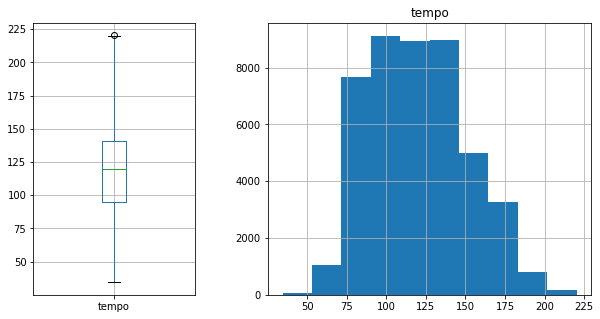

In [ ]:
fig, axes = plt.subplots(1,2, gridspec_kw={'width_ratios': [2, 4]}, figsize=(10,5))
prediction_data.boxplot(column='tempo',ax=axes[0], whis=1.75)
prediction_data.hist(column='tempo',ax=axes[1])

We can see that, as predicted, tempo has a pretty good distribution and not many outlier candidates.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff0774c59d0>],
      dtype=object)

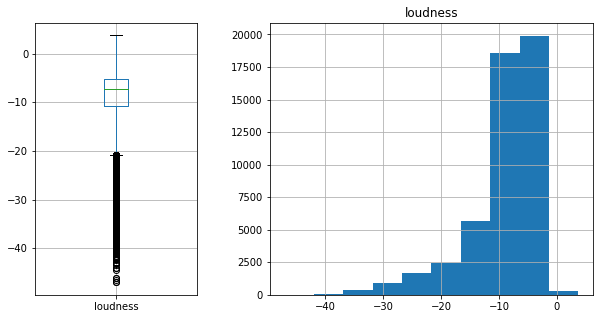

In [ ]:
fig, axes = plt.subplots(1,2, gridspec_kw={'width_ratios': [2, 4]}, figsize=(10,5))
prediction_data.boxplot(column='loudness',ax=axes[0], whis=1.75)
prediction_data.hist(column='loudness',ax=axes[1])

We can also see that loudness has some slightly extreme cases, but we considered they're still not outliers.

In [ ]:
prediction_data[prediction_data['loudness']<-42]

popularity  acousticness  danceability  ...  key_F#  key_G  key_G#
40263        40.0         0.992        0.4160  ...       0      0       0
40470        12.0         0.987        0.4310  ...       0      0       0
40755        44.0         0.994        0.0865  ...       0      0       0
41507        14.0         0.994        0.2980  ...       0      0       0
41614        32.0         0.977        0.0631  ...       0      1       0
42245        19.0         0.995        0.4150  ...       0      0       0
42339        15.0         0.985        0.4620  ...       0      0       1
43034        33.0         0.993        0.2870  ...       1      0       0
43141        37.0         0.991        0.1570  ...       0      0       0
43226        51.0         0.936        0.4100  ...       0      0       0
43282        13.0         0.996        0.3260  ...       0      0       0
43804        29.0         0.920        0.1170  ...       0      0       0
43875        24.0         0.843        0.1650  ...       0      0       0
44185        27.0         0.995        0.5590  ...       0      1       0
44321         0.0         0.989        0.2170  ...       0      0       0
44685        47.0         0.949        0.1420  ...       1      0       0
44963        24.0         0.994        0.3490  ...       0      1       0

[17 rows x 25 columns]

If we check the songs at this extreme we notice that these values still carry a great deal of information as most extremely quiet songs belong to the classical genre.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff0771d0350>],
      dtype=object)

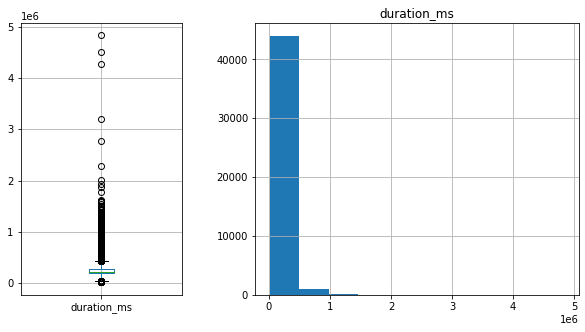

In [ ]:
fig, axes = plt.subplots(1,2, gridspec_kw={'width_ratios': [2, 4]}, figsize=(10,5))
prediction_data.boxplot(column='duration_ms',ax=axes[0], whis=1.75)
prediction_data.hist(column='duration_ms',ax=axes[1])

In [ ]:
prediction_data[prediction_data['duration_ms']>1750000]
prediction_data.shape
prediction_data = prediction_data.drop(prediction_data[prediction_data['duration_ms']>1750000].index)
prediction_data.shape

popularity  acousticness  danceability  ...  key_F#  key_G  key_G#
1410         41.0       0.00164         0.467  ...       0      0       0
2133         37.0       0.52800         0.408  ...       0      0       0
3759         34.0       0.00299         0.366  ...       0      0       0
4593         34.0       0.13800         0.478  ...       0      1       0
33508        33.0       0.12300         0.332  ...       1      0       0
41158         5.0       0.94400         0.160  ...       0      0       0
42075        26.0       0.75400         0.286  ...       0      0       0
42337        12.0       0.92500         0.263  ...       0      0       0
42726         4.0       0.98100         0.141  ...       0      0       0
43868        26.0       0.81900         0.271  ...       0      0       0

[10 rows x 25 columns]

(50000, 25)

(49990, 25)

When analyzing song durations is where we find the first clear cases of outliers. These are probably correct values, but they look to be special cases that do not represent their genre correctly and might affect our models, so we will drop them.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff07686b850>],
      dtype=object)

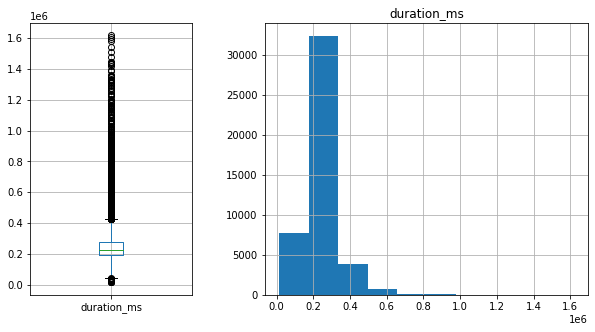

In [ ]:
fig, axes = plt.subplots(1,2, gridspec_kw={'width_ratios': [2, 4]}, figsize=(10,5))
prediction_data.boxplot(column='duration_ms',ax=axes[0], whis=1.75)
prediction_data.hist(column='duration_ms',ax=axes[1])

### Impute missing values

In [ ]:
#impute by knn
prediction_aux = prediction_data.copy()
prediction_aux['music_genre'].replace(['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap', 'Blues', 'Rock', 'Classical', 'Hip-Hop'], [0,1,2,3,4,5,6,7,8,9], inplace=True)

imputer = KNNImputer(n_neighbors=5)
prediction_aux = imputer.fit_transform(prediction_aux)

In [ ]:
prediction_aux = pd.DataFrame(data = prediction_aux)
prediction_data['duration_ms'] = prediction_aux[3]
prediction_data['tempo'] = prediction_aux[10]
prediction_data[prediction_data.duration_ms.isna() & prediction_data.tempo.isna()]

popularity  acousticness  danceability  ...  key_F#  key_G  key_G#
49990        73.0      0.674000         0.650  ...       0      0       0
49991        53.0      0.003920         0.770  ...       0      0       0
49992        55.0      0.039100         0.829  ...       0      0       0
49993        54.0      0.304000         0.642  ...       0      0       0
49994        62.0      0.010600         0.944  ...       0      0       0
49995        55.0      0.000577         0.937  ...       0      0       0
49996        57.0      0.036300         0.829  ...       0      0       0
49997        75.0      0.171000         0.587  ...       0      0       0
49998        55.0      0.474000         0.514  ...       0      0       0
49999        56.0      0.133000         0.849  ...       0      0       0
50000        59.0      0.033400         0.913  ...       0      0       0
50001        72.0      0.157000         0.709  ...       0      0       0
50002        51.0      0.005970         0.693  ...       0      0       0
50003        65.0      0.083100         0.782  ...       0      1       0
50004        67.0      0.102000         0.862  ...       1      0       0

[15 rows x 25 columns]

In [ ]:
prediction_data = prediction_data.dropna()
prediction_data[prediction_data.duration_ms.isna() & prediction_data.tempo.isna()]

Empty DataFrame
Columns: [popularity, acousticness, danceability, duration_ms, energy, instrumentalness, liveness, loudness, mode, speechiness, tempo, valence, music_genre, key_A, key_A#, key_B, key_C, key_C#, key_D, key_D#, key_E, key_F, key_F#, key_G, key_G#]
Index: []

### Train-Test split

In [ ]:
X = prediction_data.loc[:,prediction_data.columns != 'music_genre']
y = prediction_data['music_genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Normalize variables

Since most of our variables are already normalized to the range [0,1] we will only have to manually normalize popularity, duration_ms, loudness and tempo. These will be normalized using a min-max scaler computed from the train-split data.

In [ ]:
rows_to_minmax = ['popularity', 'duration_ms', 'loudness', 'tempo']
min_max_scaler =  preprocessing.MinMaxScaler()
min_max_scaler.fit(X_train[rows_to_minmax]);
X_train[rows_to_minmax] = min_max_scaler.transform(X_train[rows_to_minmax])
X_test[rows_to_minmax] = min_max_scaler.transform(X_test[rows_to_minmax])
X_train.describe()
X_test.describe()

MinMaxScaler()

popularity  acousticness  ...         key_G       key_G#
count  37481.000000  37481.000000  ...  37481.000000  37481.00000
mean       0.455893      0.306717  ...      0.115178      0.06622
std        0.160299      0.341275  ...      0.319241      0.24867
min        0.000000      0.000000  ...      0.000000      0.00000
25%        0.350515      0.020000  ...      0.000000      0.00000
50%        0.463918      0.145000  ...      0.000000      0.00000
75%        0.577320      0.554000  ...      0.000000      0.00000
max        1.000000      0.996000  ...      1.000000      1.00000

[8 rows x 24 columns]

popularity  acousticness  ...         key_G        key_G#
count  12494.000000  12494.000000  ...  12494.000000  12494.000000
mean       0.455799      0.305396  ...      0.112694      0.066992
std        0.159907      0.341547  ...      0.316231      0.250018
min        0.000000      0.000001  ...      0.000000      0.000000
25%        0.350515      0.020100  ...      0.000000      0.000000
50%        0.463918      0.142000  ...      0.000000      0.000000
75%        0.567010      0.546000  ...      0.000000      0.000000
max        1.020619      0.996000  ...      1.000000      1.000000

[8 rows x 24 columns]

### Pre-processed data visualization

We will also separately normalize the full dataset with all samples  so we can visualize the whole initial set:

In [ ]:
rows_to_minmax = ['popularity', 'duration_ms', 'loudness', 'tempo']
min_max_scaler =  preprocessing.MinMaxScaler()
prediction_data[rows_to_minmax] = min_max_scaler.fit_transform(prediction_data[rows_to_minmax]);
prediction_data.describe()

popularity  acousticness  ...         key_G        key_G#
count  49975.000000  49975.000000  ...  49975.000000  49975.000000
mean       0.446660      0.306387  ...      0.114557      0.066413
std        0.156963      0.341340  ...      0.318490      0.249005
min        0.000000      0.000000  ...      0.000000      0.000000
25%        0.343434      0.020000  ...      0.000000      0.000000
50%        0.454545      0.144000  ...      0.000000      0.000000
75%        0.565657      0.552000  ...      0.000000      0.000000
max        1.000000      0.996000  ...      1.000000      1.000000

[8 rows x 24 columns]

First we will analize the distribution of each variable independently of genre

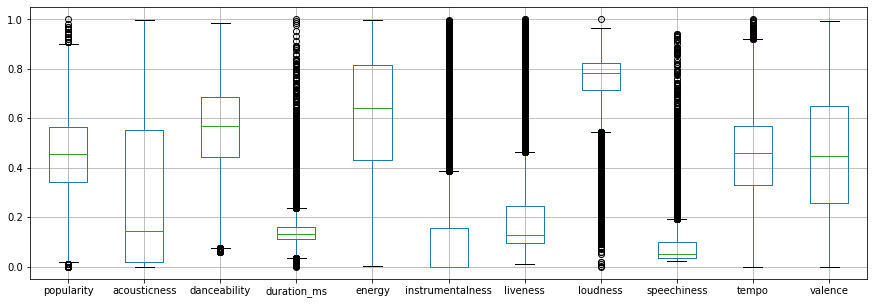

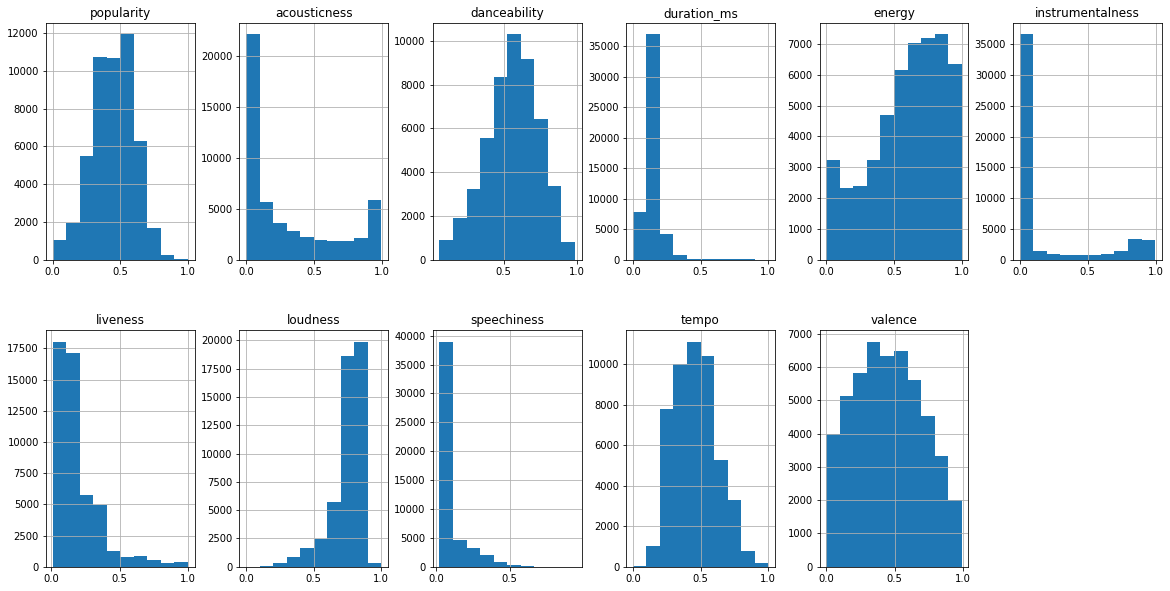

In [ ]:
data_columns = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
fig, ax = plt.subplots(figsize=(15,5))
prediction_data[data_columns].boxplot()
prediction_data[data_columns].hist(figsize=(20,10), layout=(2,6));

Now we will also look at the distribution of each variable according to each genre. Here we can start to notice some patterns and which variables might be more useful than others.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff06dcdb2d0>,
      dtype=object)

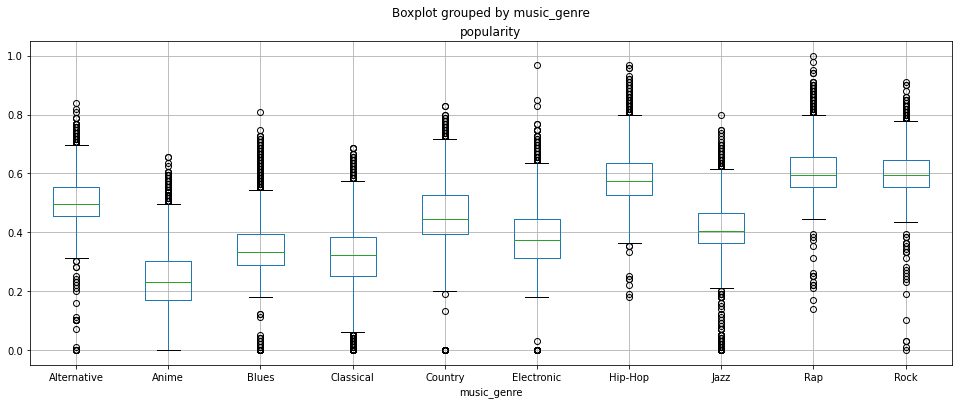

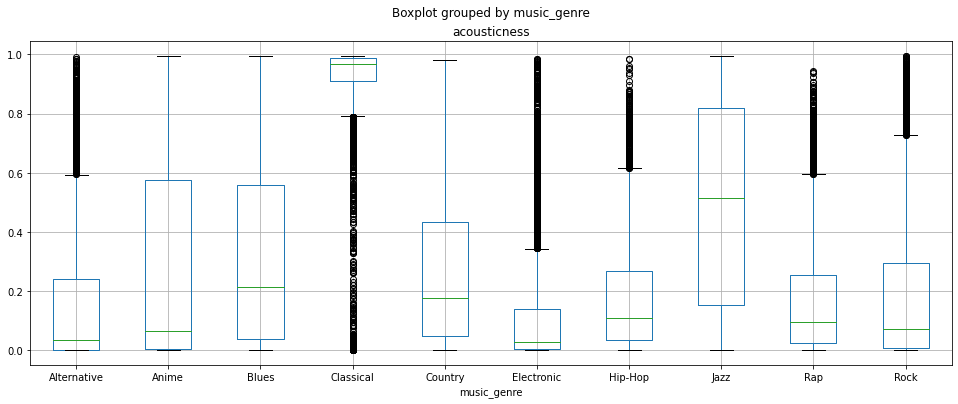

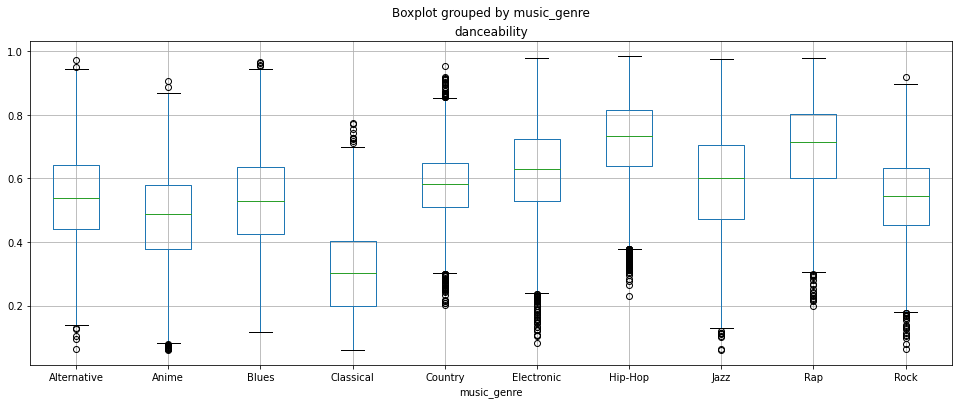

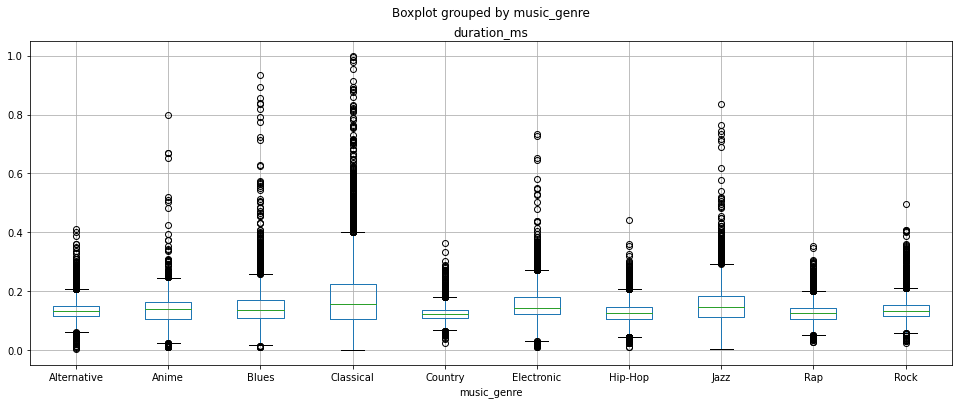

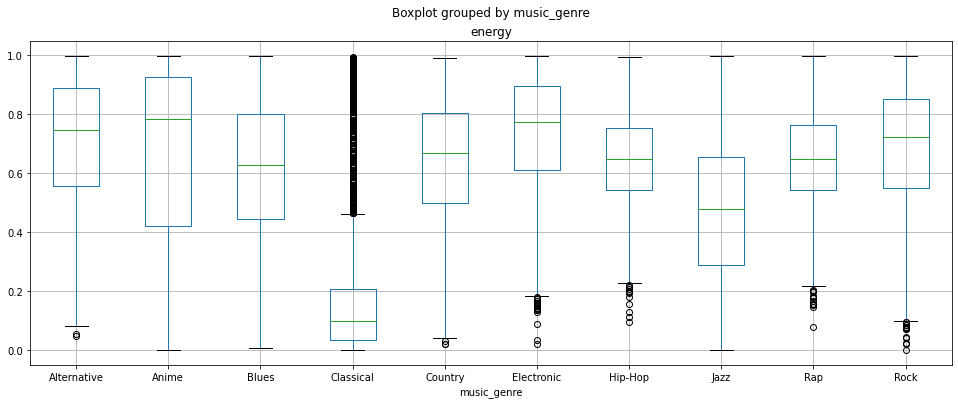

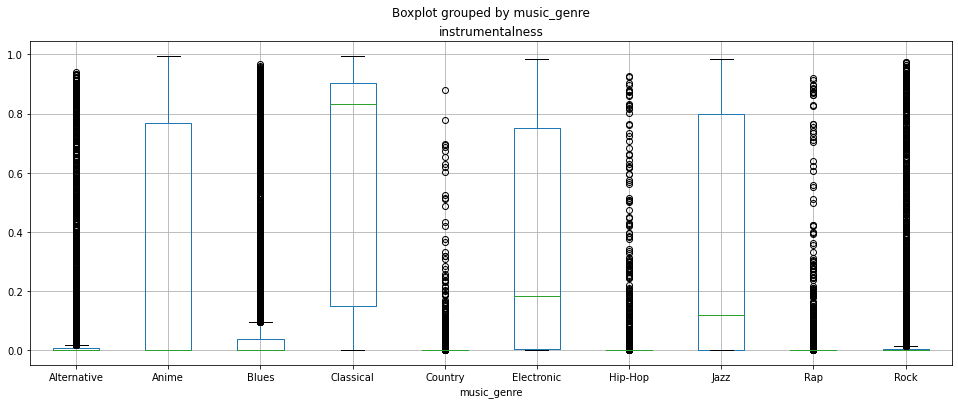

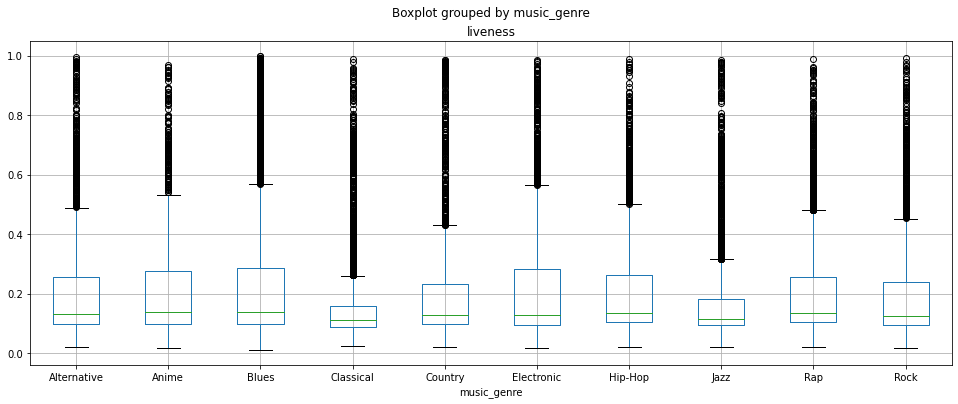

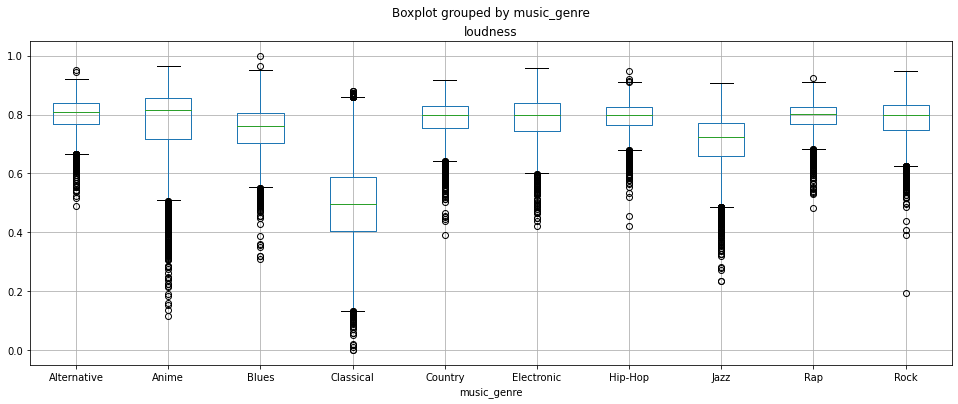

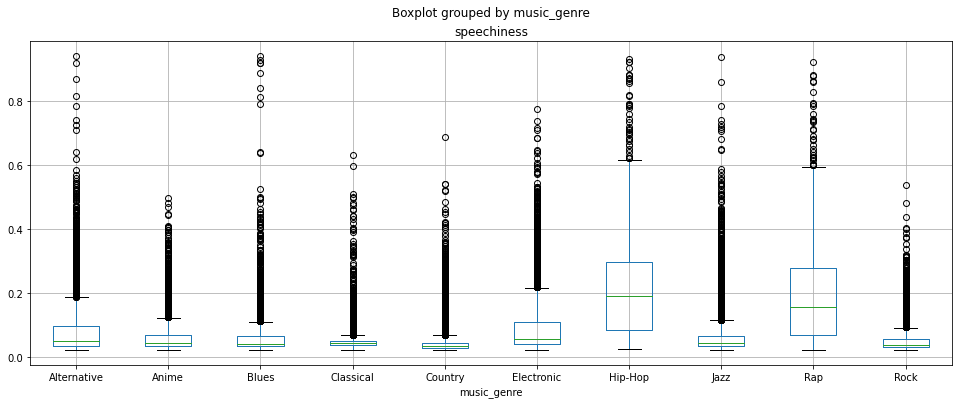

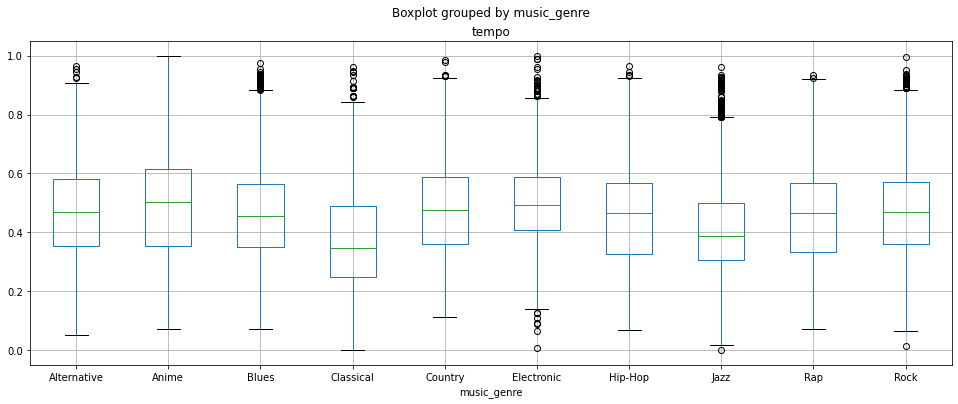

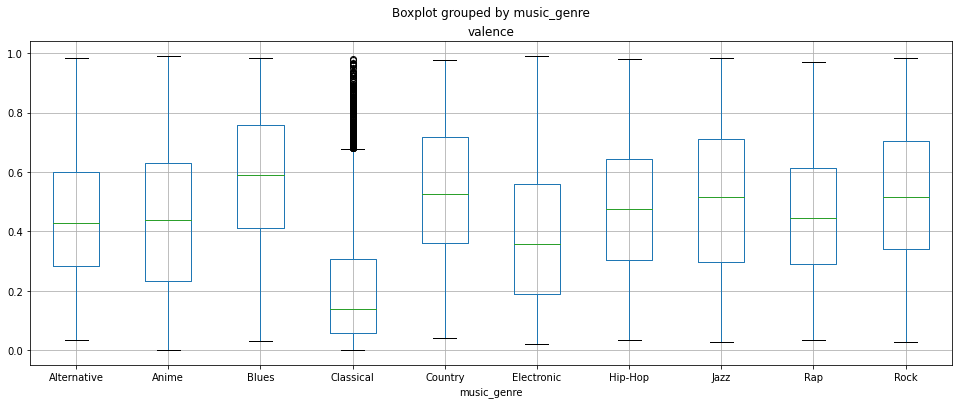

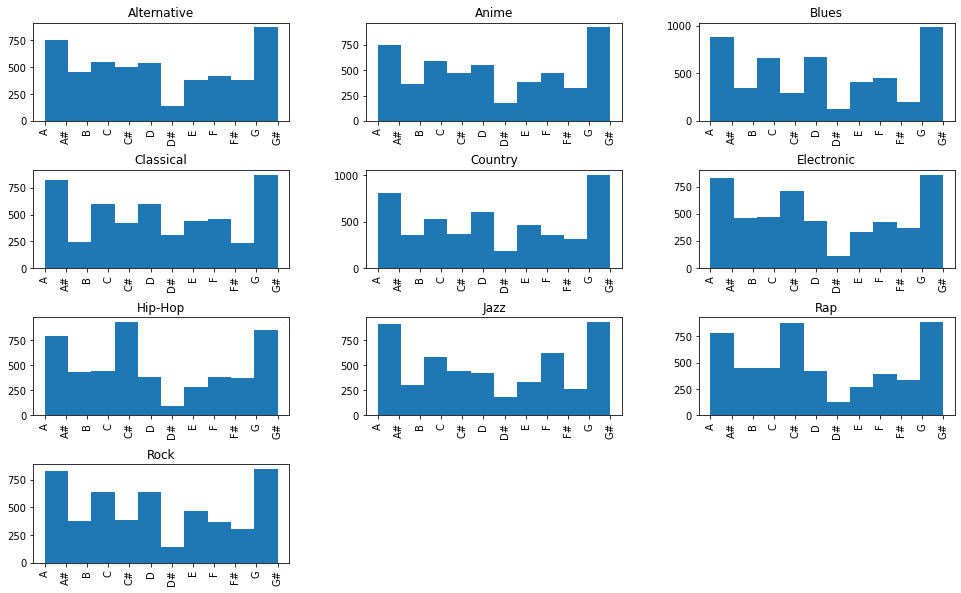

In [ ]:
prediction_data.boxplot(column='popularity', by='music_genre',figsize=(16,6));
prediction_data.boxplot(column='acousticness', by='music_genre',figsize=(16,6));
prediction_data.boxplot(column='danceability', by='music_genre',figsize=(16,6));
prediction_data.boxplot(column='duration_ms', by='music_genre',figsize=(16,6));
prediction_data.boxplot(column='energy', by='music_genre',figsize=(16,6));
prediction_data.boxplot(column='instrumentalness', by='music_genre',figsize=(16,6));
prediction_data.boxplot(column='liveness', by='music_genre',figsize=(16,6));
prediction_data.boxplot(column='loudness', by='music_genre',figsize=(16,6));
prediction_data.boxplot(column='speechiness', by='music_genre',figsize=(16,6));
prediction_data.boxplot(column='tempo', by='music_genre',figsize=(16,6));
prediction_data.boxplot(column='valence', by='music_genre',figsize=(16,6));
# we use music data for this because key hasn't been transformed yet:
music_data = music_data.sort_values('key')
music_data.hist(column='key',by='music_genre',figsize=(16,10))

**[ ! ]** This pltot takes a while to execute and display

In [ ]:
sns.pairplot(prediction_data[data_columns+['music_genre']], hue='music_genre');

Finally we will take a look at the correlation between all our variables in a correlation matrix:

In [ ]:
output = associations(prediction_data,nan_strategy='drop_samples',figsize=(18,18))

correlation = output['corr']
ax = output['ax']

correlation

# 2. Testing Classificators

## linear/quadratic methods

### LDA (Linear Discriminant Analysis)

In [ ]:
lda = LinearDiscriminantAnalysis().fit(X_train,y_train)
print('Priors: ',lda.priors_)
print('Means:')
means = pd.DataFrame(lda.means_)
means.columns=X_train.columns
means['genre'] = lda.classes_
means.loc[:,['genre']+X_train.columns.to_list()]
print('Coeficients:')
coefs = pd.DataFrame(lda.coef_)
coefs.columns = X_train.columns
coefs['genre'] = lda.classes_
coefs.loc[:,['genre']+X_train.columns.to_list()]
print('Intercepts:')
intercepts = pd.DataFrame(lda.intercept_)
intercepts['genre'] = lda.classes_
intercepts


Priors:  [0.09958396 0.09931726 0.09905057 0.10139748 0.10062407 0.0993706
 0.09987732 0.10105078 0.09953062 0.10019735]
Means:


genre  popularity  acousticness  ...    key_F#     key_G    key_G#
0  Alternative    0.508170      0.164509  ...  0.073380  0.112748  0.065078
1        Anime    0.245847      0.281979  ...  0.065252  0.116273  0.066864
2        Blues    0.350933      0.317426  ...  0.040118  0.151589  0.045773
3    Classical    0.297061      0.866993  ...  0.046554  0.115203  0.056549
4      Country    0.464842      0.270137  ...  0.064670  0.138351  0.059634
5   Electronic    0.386492      0.123373  ...  0.074879  0.106549  0.064144
6      Hip-Hop    0.591080      0.176690  ...  0.074766  0.076903  0.091055
7         Jazz    0.412752      0.492912  ...  0.052257  0.118501  0.072579
8          Rap    0.611374      0.166557  ...  0.066184  0.088424  0.086817
9         Rock    0.602294      0.189185  ...  0.059622  0.117115  0.057227

[10 rows x 25 columns]

Coeficients:


genre  popularity  acousticness  ...    key_F#     key_G    key_G#
0  Alternative    6.094150     -1.028698  ...  0.129108  0.017117 -0.075057
1        Anime  -22.036298      0.545885  ...  0.093086  0.004245  0.131680
2        Blues  -10.502132     -0.015823  ... -0.329091  0.263241 -0.282479
3    Classical  -13.928308      4.111761  ...  0.057598 -0.161664  0.059473
4      Country    1.294686      0.052626  ...  0.121956  0.115714 -0.280112
5   Electronic   -6.798910     -1.139903  ...  0.182498 -0.040069  0.074350
6      Hip-Hop   15.448246     -1.692560  ...  0.038526 -0.160461  0.254506
7         Jazz   -3.413543      1.895734  ... -0.143088  0.053682  0.207889
8          Rap   17.556747     -1.786051  ... -0.097225 -0.063943  0.189794
9         Rock   16.309372     -1.036971  ... -0.054535 -0.024990 -0.281181

[10 rows x 25 columns]

Intercepts:


0        genre
0  -6.516042  Alternative
1   1.961222        Anime
2   2.031521        Blues
3  20.046104    Classical
4  -5.979129      Country
5  -6.379012   Electronic
6 -17.659437      Hip-Hop
7  -4.044767         Jazz
8 -18.048061          Rap
9 -10.140193         Rock

In [ ]:
y_pred = lda.predict(X_test)
print('LDA score: ', lda.score(X_test,y_test))
print('\nCross Validation Score: ',cross_val_score(lda,X_test,y_test,cv=5))
print('Confusion Matrix:')
confusion(y_test, y_pred, lda.classes_)

LDA score:  0.5186814945195616

Cross Validation Score:  [0.5108     0.5004     0.5112     0.5332     0.50860344]
Confusion Matrix:


Predicted    Alternative  Anime  Blues  Classical  ...  Hip-Hop  Jazz  Rap  Rock
Actual                                             ...                          
Alternative          471      8     30          1  ...      143    68   41   199
Anime                 52    745    155        161  ...        0    48    0     3
Blues                 69    202    633         21  ...        8   125    2    56
Classical             31     40     32       1001  ...        0    54    0     3
Country              123     21    177          2  ...       21    22    7   193
Electronic            97    103     89         17  ...       72    82   24    27
Hip-Hop              100      0      4          0  ...      639    11  343    88
Jazz                  42     52    156         86  ...       45   460    8    41
Rap                  121      0      0          0  ...      527    11  391   174
Rock                 193      3     10          5  ...       18    30   56   792

[10 rows x 10 columns]

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

 Alternative       0.36      0.37      0.37      1266
       Anime       0.63      0.58      0.61      1276
       Blues       0.49      0.49      0.49      1286
   Classical       0.77      0.84      0.80      1198
     Country       0.44      0.52      0.48      1227
  Electronic       0.61      0.56      0.58      1274
     Hip-Hop       0.43      0.51      0.47      1250
        Jazz       0.50      0.38      0.43      1211
         Rap       0.45      0.31      0.37      1268
        Rock       0.50      0.64      0.56      1243

    accuracy                           0.52     12499
   macro avg       0.52      0.52      0.52     12499
weighted avg       0.52      0.52      0.52     12499



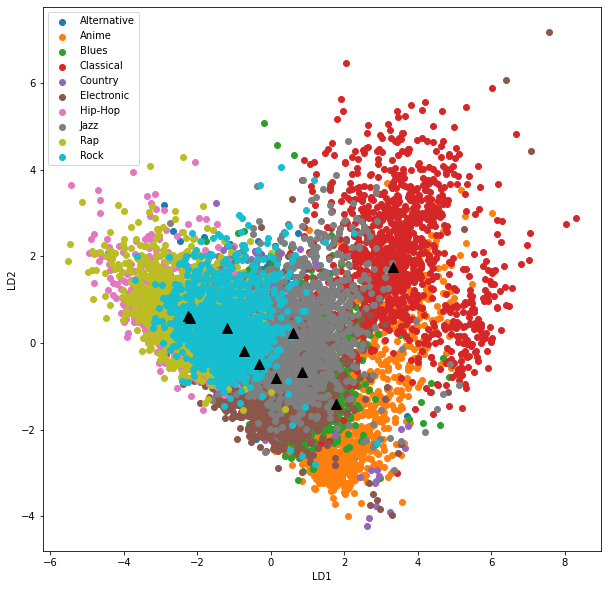

In [ ]:
test_trans = lda.transform(X_test)
fig, ax = plt.subplots(figsize=(10,10))
for genre in lda.classes_:
    plt.scatter(test_trans[:,0][y_test==genre], test_trans[:,1][y_test==genre], label=genre)
    plt.plot(test_trans[:,0][y_test==genre].mean(), test_trans[:,1][y_test==genre].mean(), 'k^', markersize=10)
ax.set_xlabel('LD1')
ax.set_ylabel('LD2')
plt.legend();

We can see that LDA certainly groups together sets of songs, but from their scores and how close they are we can tell that it doesn't do a great job of it. This being said, it does a slightly better job of telling appart classical music (and anime to a certain extent) from the rest. This is probably due to them being the most different genres of the bunch.

### QDA (Quadratic Discriminant Analysis)

In [ ]:
qda = QuadraticDiscriminantAnalysis().fit(X_train,y_train)
print('Priors:', qda.priors_)
print('Means:\n')
means = pd.DataFrame(qda.means_)
means.columns=X_train.columns
means['genre'] = qda.classes_
means.loc[:,['genre']+X_train.columns.to_list()]

Priors: [0.09958396 0.09931726 0.09905057 0.10139748 0.10062407 0.0993706
 0.09987732 0.10105078 0.09953062 0.10019735]
Means:



genre  popularity  acousticness  ...    key_F#     key_G    key_G#
0  Alternative    0.508170      0.164509  ...  0.073380  0.112748  0.065078
1        Anime    0.245847      0.281979  ...  0.065252  0.116273  0.066864
2        Blues    0.350933      0.317426  ...  0.040118  0.151589  0.045773
3    Classical    0.297061      0.866993  ...  0.046554  0.115203  0.056549
4      Country    0.464842      0.270137  ...  0.064670  0.138351  0.059634
5   Electronic    0.386492      0.123373  ...  0.074879  0.106549  0.064144
6      Hip-Hop    0.591080      0.176690  ...  0.074766  0.076903  0.091055
7         Jazz    0.412752      0.492912  ...  0.052257  0.118501  0.072579
8          Rap    0.611374      0.166557  ...  0.066184  0.088424  0.086817
9         Rock    0.602294      0.189185  ...  0.059622  0.117115  0.057227

[10 rows x 25 columns]

In [ ]:
y_pred = qda.predict(X_test)
print('QDA score: ', qda.score(X_test,y_test))
print('\nCross Validation Score: ',cross_val_score(qda,X_test,y_test,cv=5))
print('Confusion Matrix:')
confusion(y_test, y_pred, qda.classes_)

QDA score:  0.4396351708136651

Cross Validation Score:  [0.4236     0.406      0.424      0.4204     0.42737095]
Confusion Matrix:


Predicted    Alternative  Anime  Blues  Classical  ...  Hip-Hop  Jazz  Rap  Rock
Actual                                             ...                          
Alternative          225      8     65         11  ...      128    37  176   164
Anime                 26    494    212        184  ...        1    39   10     7
Blues                 34    104    528         36  ...       16   109   11    48
Classical             10     73     37        991  ...        0    35    1     5
Country               44     10    126          6  ...       77    24   76    88
Electronic            57     77    102         28  ...       66   103   58    31
Hip-Hop               36      0      7          0  ...      471    19  569    60
Jazz                  37     61    195        159  ...       44   311   25    33
Rap                   39      0      6          1  ...      431    12  585   115
Rock                  90      2     39         27  ...       97    28  151   478

[10 rows x 10 columns]

We can see that our score is even worse when using QDA, so using a fancier version of discriminant analysis will not work for our use case...

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

 Alternative       0.38      0.18      0.24      1266
       Anime       0.60      0.39      0.47      1276
       Blues       0.40      0.41      0.41      1286
   Classical       0.69      0.83      0.75      1198
     Country       0.34      0.62      0.44      1227
  Electronic       0.48      0.51      0.49      1274
     Hip-Hop       0.35      0.38      0.36      1250
        Jazz       0.43      0.26      0.32      1211
         Rap       0.35      0.46      0.40      1268
        Rock       0.46      0.38      0.42      1243

    accuracy                           0.44     12499
   macro avg       0.45      0.44      0.43     12499
weighted avg       0.45      0.44      0.43     12499



###KNN (K Nearest Neighbors)

Plot the accuracy depending on the K value

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'accuracy vs. K Value')

Text(0.5, 0, 'K')

Text(0, 0.5, 'Accuracy')

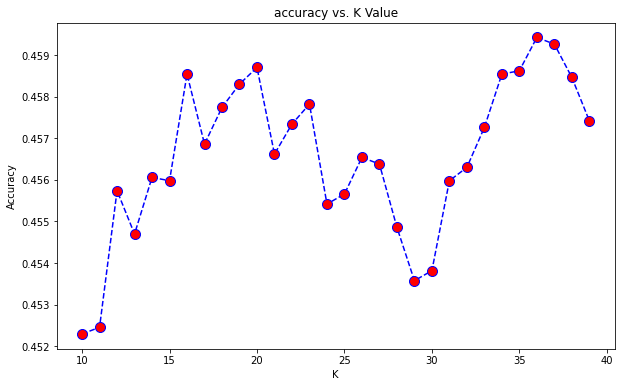

In [ ]:
acc = []
from sklearn import metrics
for i in range(10,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, yhat))

plt.figure(figsize=(10,6))
plt.plot(range(10,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')

**[ ! ]** Finding the best hyperparameter combination (K and distance metrics). Only execute to retest, as it takes a while:

In [ ]:
ks = [35,36,37,38,39]
metrics = ['euclidean', 'manhattan', 'mahalanobis', 'minkowski']

model_knn = KNeighborsClassifier()

knn = GridSearchCV(estimator=model_knn,
                   param_grid={'n_neighbors':ks,
                               'metric':metrics
                   },
                   scoring=['accuracy', 'recall_macro'],
                   cv=5,
                   return_train_score=True,
                  refit='recall_macro')

model_4CV = knn.fit(X_train, y_train)
model_4CV.best_score_

0.46477389299775307

In [ ]:
model_4CV.best_params_

{'metric': 'manhattan', 'n_neighbors': 39}

Training a KNN classifier with the best parameters found (manhatan distance calculation and 14 nearest neighbors). Execute this if you only want the final KNN results:

In [ ]:
myknn = KNeighborsClassifier(n_neighbors=36, metric='manhattan')
myknn.fit(X_train, y_train);

y_pred = myknn.predict(X_test)

print('\nCross Validation Score: ',cross_val_score(myknn, X_test, y_test, cv=5))
print('\n',classification_report(y_test,y_pred))
confusion(y_test,y_pred, myknn.classes_)

KNeighborsClassifier(metric='manhattan', n_neighbors=36)


Cross Validation Score:  [0.41256503 0.42897159 0.43337335 0.41976791 0.41072858]

               precision    recall  f1-score   support

 Alternative       0.34      0.37      0.35      1264
       Anime       0.66      0.45      0.54      1274
       Blues       0.57      0.35      0.43      1270
   Classical       0.72      0.85      0.78      1238
     Country       0.34      0.64      0.45      1254
  Electronic       0.59      0.49      0.54      1274
     Hip-Hop       0.39      0.44      0.41      1241
        Jazz       0.47      0.39      0.43      1214
         Rap       0.39      0.33      0.36      1243
        Rock       0.45      0.44      0.45      1222

    accuracy                           0.47     12494
   macro avg       0.49      0.47      0.47     12494
weighted avg       0.49      0.47      0.47     12494



Predicted    Alternative  Anime  Blues  Classical  ...  Hip-Hop  Jazz  Rap  Rock
Actual                                             ...                          
Alternative          465     21     19          1  ...      128    41   84   166
Anime                 76    576     86        200  ...        1    62    2     9
Blues                 96    127    441         22  ...       13   158    6    43
Classical             37     16     24       1051  ...        0    56    0     2
Country              112     24     52          2  ...       34    32   31   161
Electronic           148     92     42          9  ...       76   112   31    21
Hip-Hop               62      1      3          0  ...      544    14  419    96
Jazz                  45     14    100        149  ...       46   476   25    30
Rap                   95      0      3          1  ...      515    16  414   126
Rock                 220      1      8         16  ...       52    36   60   538

[10 rows x 10 columns]

### SVM (Support Vector Machine)

**[ ! ]** Finding the best C value for our SVM. Only execute to restest, as it takes a while:

In [ ]:
svm = SVC(class_weight='balanced', kernel = 'linear')
Cs = [0.1,1, 10, 100]

trc = GridSearchCV(estimator=svm,
                   param_grid={
                       'C': Cs,
                   },
                   scoring=['accuracy', 'recall_macro', 'f1_macro'],
                   cv=5,
                   return_train_score=True,
                   refit='f1_macro')

model_3CV = trc.fit(X_train, y_train)

model_3CV.best_score_

0.5375784549394123

{'C': 100}

In [ ]:
model_3CV.best_params_

{'C': 100}

Using a linear suport vector classificator we obtain a slightly better score than using LDA (0.53). With the exploration of the regularization parameter C, the best result is when C = 100, so we will train the best model obtained with this parameter. Execute this if you want the final SVM results:

In [ ]:
svm = SVC(kernel='linear',class_weight='balanced', C=100)
svm.fit(X_train,y_train)

scores = cross_val_score(svm, X_test, y_test, cv=5)
scores_recall = cross_val_score(svm, X_test, y_test, cv=5,scoring='recall_macro')
scores_f_score = cross_val_score(svm, X_test, y_test, cv=5,scoring='f1_macro')

SVC(C=100, class_weight='balanced', kernel='linear')

In [ ]:
print('Accuracy: ')
np.mean(scores)

Accuracy: 


0.5388983455672101

In [ ]:
print('Recall (mean): ')
np.mean(scores_recall)

Recall (mean): 


0.5392256024560848

In [ ]:
print('F-score (mean): ')
np.mean(scores_f_score)

F-score (mean): 


0.5352190741010583

In [ ]:
y_pred = svm.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

 Alternative       0.42      0.36      0.39      1264
       Anime       0.63      0.63      0.63      1274
       Blues       0.55      0.45      0.49      1270
   Classical       0.78      0.82      0.80      1238
     Country       0.47      0.55      0.51      1254
  Electronic       0.63      0.58      0.60      1274
     Hip-Hop       0.45      0.52      0.49      1241
        Jazz       0.53      0.47      0.50      1214
         Rap       0.47      0.36      0.41      1243
        Rock       0.51      0.70      0.59      1222

    accuracy                           0.54     12494
   macro avg       0.54      0.55      0.54     12494
weighted avg       0.54      0.54      0.54     12494



In [ ]:
print('Confusion Matrix:')
confusion(y_test, y_pred, svm.classes_)

Confusion Matrix:


Predicted    Alternative  Anime  Blues  Classical  ...  Hip-Hop  Jazz  Rap  Rock
Actual                                             ...                          
Alternative          452      7     33          3  ...      131    60   35   218
Anime                 35    806    108        135  ...        0    33    0     8
Blues                 47    210    574         20  ...        2   150    0    57
Classical             23     72     23       1020  ...        0    54    0     3
Country               96     20    106          1  ...       23    43   11   230
Electronic            82    106     76         10  ...       33   120   27    21
Hip-Hop               84      0      0          0  ...      651    13  370    84
Jazz                  42     59    127        108  ...       33   567    2    46
Rap                   76      1      1          0  ...      530     8  449   148
Rock                 137      1      3          5  ...       34    26   63   854

[10 rows x 10 columns]

##non-linear methods

###MLP (Multilayer Perceptron)

In [ ]:
y_train_num = y_train.replace(['Alternative', 'Anime', 'Blues', 'Classical', 'Country', 'Electronic', 'Hip-Hop', 'Jazz', 'Rap', 'Rock'], [0,1,2,3,4,5,6,7,8,9])
y_test_num = y_test.replace(['Alternative', 'Anime', 'Blues', 'Classical', 'Country', 'Electronic', 'Hip-Hop', 'Jazz', 'Rap', 'Rock'], [0,1,2,3,4,5,6,7,8,9])
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)

**[ ! ]** Finding the best architecture. Only execute this if you want to retest the results, as it may take a while.

In [ ]:
act = 'relu'
# first small architectures
#architectures = [(10,5), (12,9), (8,8), (6,12), (4,11)]
# these ones give us around 0.57-0.58 max accuracy:
architectures = [(96, 32, 64, 32, 22), (192, 64, 96, 24, 32, 64, 16, 32), (192, 64, 96, 24, 32, 64, 13), (200, 75, 100, 25, 40, 50, 15), (196,96,64,32,64,24,15), (500,150,100,125,50,75,200,125,150,50,25,15),(200,150,145,125,100,90,75,50,45,25,20,15,13)]
error = []
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=7, restore_best_weights=True)
for layers in architectures:
    input = keras.Input(shape=(24,))
    model = keras.layers.Dense(layers[0], activation=act)(input)
    for layer in layers[1:]:
        model = keras.layers.Dense(layer, activation=act)(model)
    model = keras.layers.Dense(10, activation='softmax')(model)
    nn = keras.Model(input, model)

    nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    error.append(nn.fit(X_train, y_train_num, epochs=100, verbose=False, validation_data=(X_test,y_test_num), callbacks=[earlystopping]))

In [ ]:
print('( first_layer_neurons, second_layer_neurons, ... )')
i = 0
for arch in architectures:
  if(i < len(error)):
    print(arch,':', error[i].history["accuracy"])
  i += 1

( first_layer_neurons, second_layer_neurons, ... )
(96, 32, 64, 32, 22) : [0.4310450553894043, 0.5098583102226257, 0.5306688547134399, 0.5408073663711548, 0.5477175116539001, 0.5544942617416382, 0.5558016300201416, 0.5598303079605103, 0.5638590455055237, 0.5622048377990723, 0.5648728609085083, 0.5703690052032471, 0.5691683888435364, 0.5714095234870911, 0.5761585831642151, 0.5775993466377258, 0.5782396197319031, 0.5782396197319031, 0.5802940130233765, 0.5803740620613098, 0.5811210870742798, 0.5816013216972351, 0.5823217034339905, 0.5865371823310852, 0.5849096775054932, 0.5850697755813599, 0.5865905284881592, 0.5891785025596619, 0.5883781313896179, 0.5912595987319946, 0.5910727977752686, 0.5926735997200012, 0.5906459093093872, 0.5948347449302673, 0.59371417760849, 0.5973159670829773, 0.59718257188797, 0.5973159670829773, 0.5975561141967773, 0.597876250743866, 0.598756730556488]
(192, 64, 96, 24, 32, 64, 16, 32) : [0.3767508864402771, 0.4740268290042877, 0.5066033601760864, 0.523892104625

we will now use one of the best architectures we found, (200, 75, 100, 25, 40, 50, 15). Execute this if you only want the final MLP results

In [ ]:
layers = (200, 75, 100, 25, 40, 50, 15)

input = keras.Input(shape=(24,))
model = keras.layers.Dense(layers[0], activation='relu')(input)
for layer in layers[1:]:
    model = keras.layers.Dense(layer, activation='relu')(model)
model = keras.layers.Dense(10, activation='softmax')(model)
nn = keras.Model(input, model)

nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fitted_mlp = nn.fit(X_train, y_train_num, epochs=30, verbose=False, validation_data=(X_test,y_test_num), callbacks=[earlystopping])
print(fitted_mlp.history)

In [ ]:
y_pred_aux = nn.predict(X_train)

y_pred = []
for line in y_pred_aux:
    max = 0
    max_pos = 0
    for i, score in enumerate(line):
        if score > max:
            max = score 
            max_pos = i
    y_pred.append(max_pos)

print(classification_report(y_train_num, y_pred, target_names=['Alternative', 'Anime', 'Blues', 'Classical', 'Country', 'Electronic', 'Hip-Hop', 'Jazz', 'Rap', 'Rock']))
confusion(y_train_num, y_pred, ['Alternative', 'Anime', 'Blues', 'Classical', 'Country', 'Electronic', 'Hip-Hop', 'Jazz', 'Rap', 'Rock'])

###Random Forest

**[ ! ]** Finding best random forest hyperparameters. Only execute to restest, as it takes a while:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV


n_estimators = [100, 150, 200, 500]
max_depth = [5, 10, 15, 30, 50, None]
max_depth.append(None)
min_samples_split = [1, 2, 3]
min_samples_leaf = [1, 2, 3]
crit = ['gini']
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': crit}

rf_model = RandomForestClassifier(class_weight='balanced')

trc = RandomizedSearchCV(estimator = rf_model, 
                         param_distributions = random_grid, 
                         n_iter = 100, 
                         cv = 5, 
                         verbose=2, 
                         random_state=42, 
                         n_jobs = -1,
                         scoring=['accuracy', 'f1', 'f1_macro','recall_macro'],
                         refit='recall_macro')

model_10CV = trc.fit(X_train, y_train)


model_10CV.best_score_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
model_10CV.best_params_

Training a Random Forest classifier with the best parameters found. Execute this if you only want the final random forest results.

In [ ]:
rf = RandomForestClassifier(class_weight='balanced',
                                  max_depth=15,
                                  min_samples_leaf=4,
                                  min_samples_split=4,
                                  n_estimators=200);
rf.fit(X_train, y_train);

y_pred = rf.predict(X_test)
print('\nCross Validation Score: ',cross_val_score(rf,X_test,y_test))

RandomForestClassifier(class_weight='balanced', max_depth=100,
                       min_samples_leaf=4, min_samples_split=4,
                       n_estimators=200)


Cross Validation Score:  [0.5712     0.572      0.5836     0.5776     0.56422569]
              precision    recall  f1-score   support

 Alternative       0.48      0.33      0.39      1266
       Anime       0.81      0.74      0.77      1276
       Blues       0.64      0.55      0.59      1286
   Classical       0.83      0.87      0.85      1198
     Country       0.58      0.60      0.59      1227
  Electronic       0.67      0.64      0.65      1274
     Hip-Hop       0.36      0.41      0.39      1250
        Jazz       0.53      0.53      0.53      1211
         Rap       0.35      0.31      0.33      1268
        Rock       0.49      0.73      0.58      1243

    accuracy                           0.57     12499
   macro avg       0.57      0.57      0.57     12499
weighted avg       0.57      0.57      0.57     12499



Predicted    Alternative  Anime  Blues  Classical  ...  Hip-Hop  Jazz  Rap  Rock
Actual                                             ...                          
Alternative          413     16     25          0  ...      124   103   47   295
Anime                 21    942     66        110  ...        0    25    0    11
Blues                 54     92    703         23  ...        9   160    0    76
Classical             33     19     29       1042  ...        0    50    1     2
Country               78     22     57          1  ...       15    48   16   243
Electronic            63     59     76          7  ...       19   135   16    43
Hip-Hop               42      0      3          0  ...      518    11  573    73
Jazz                  32     13    138         77  ...       23   645   10    57
Rap                   36      0      1          0  ...      661    12  388   158
Rock                  94      5      6          3  ...       51    33   55   909

[10 rows x 10 columns]

In [ ]:
print(classification_report(y_test, y_pred, target_names=rf.classes_))
confusion(y_test,y_pred, rf.classes_)